In [1]:
"""Example of using training on CartPole."""

#import argparse
#/Users/felix/miniconda3/envs/customjssp/lib/python3.10/site-packages/ray/rllib/agents/mbmpo/model_ensemble.py

import ray
from ray import tune
from ray.rllib.agents.mbmpo.model_ensemble import DynamicsEnsembleCustomModel
from ray.rllib.examples.env.mbmpo_env import CartPoleWrapper
from ray.rllib.models.catalog import ModelCatalog
from ray.rllib.agents.mbmpo.utils import MBMPOExploration 
from ray.rllib.env.wrappers.model_vector_env import model_vector_env
from ray.rllib.utils.deprecation import DEPRECATED_VALUE
from ray.rllib.agents.mbmpo.mbmpo import MBMPOTrainer
train=True
#parser = argparse.ArgumentParser()
#parser.add_argument("--num-workers", default=6, type=int)
#parser.add_argument("--training-iteration", default=10000, type=int)
#parser.add_argument("--ray-num-cpus", default=7, type=int)
#args = parser.parse_args()
ray.shutdown()
ray.init(num_cpus=7)

ModelCatalog.register_custom_model("DynamicsEnsembleCustomModel", DynamicsEnsembleCustomModel)

config={
    "env": CartPoleWrapper,
    "use_gae": True,
    # GAE(lambda) parameter.
    "lambda": 1.0,
    # Initial coefficient for KL divergence.
    "kl_coeff": 0.0005,
    # Size of batches collected from each worker.
    "rollout_fragment_length": 200,
    # Do create an actual env on the local worker (worker-idx=0).
    "create_env_on_driver": True,
    # Step size of SGD.
    "lr": 1e-3,
    # Coefficient of the value function loss.
    "vf_loss_coeff": 0.5,
    # Coefficient of the entropy regularizer.
    "entropy_coeff": 0.0,
    # PPO clip parameter.
    "clip_param": 0.5,
    # Clip param for the value function. Note that this is sensitive to the
    # scale of the rewards. If your expected V is large, increase this.
    "vf_clip_param": 10.0,
    # If specified, clip the global norm of gradients by this amount.
    "grad_clip": None,
    # Target value for KL divergence.
    "kl_target": 0.01,
    # Whether to rollout "complete_episodes" or "truncate_episodes".
    "batch_mode": "complete_episodes",
    # Which observation filter to apply to the observation.
    "observation_filter": "NoFilter",
    # Number of Inner adaptation steps for the MAML algorithm.
    "inner_adaptation_steps": 1,
    # Number of MAML steps per meta-update iteration (PPO steps).
    "maml_optimizer_steps": 8,
    # Inner adaptation step size.
    "inner_lr": 1e-3,
    # Horizon of the environment (200 in MB-MPO paper).
    "horizon": 200,
    # Dynamics ensemble hyperparameters.
    "dynamics_model": {
        "custom_model": DynamicsEnsembleCustomModel,
        # Number of Transition-Dynamics (TD) models in the ensemble.
        "ensemble_size": 5,
        # Hidden layers for each model in the TD-model ensemble.
        "fcnet_hiddens": [512, 512, 512],
        # Model learning rate.
        "lr": 1e-3,
        # Max number of training epochs per MBMPO iter.
        "train_epochs": 500,
        # Model batch size.
        "batch_size": 500,
        # Training/validation split.
        "valid_split_ratio": 0.2,
        # Normalize data (obs, action, and deltas).
        "normalize_data": True,
    },
    # Exploration for MB-MPO is based on StochasticSampling, but uses 8000
    # random timesteps up-front for worker=0.
    "exploration_config": {
        "type": MBMPOExploration,
        "random_timesteps": 8000,
    },
    # Workers sample from dynamics models, not from actual envs.
    "custom_vector_env": model_vector_env,
    # How many iterations through MAML per MBMPO iteration.
    "num_maml_steps": 10,

    # Deprecated keys:
    # Share layers for value function. If you set this to True, it's important
    # to tune vf_loss_coeff.
    # Use config.model.vf_share_layers instead.
    "vf_share_layers": DEPRECATED_VALUE,
}

from contextlib import contextmanager
import sys, os
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
with suppress_stdout():
    trainer = MBMPOTrainer(
        config=config,
        env="ray.rllib.examples.env.mbmpo_env.CartPoleWrapper")

env = CartPoleWrapper()
iteration_list=[]
epoch_nr=0
for _ in range(50):
    epoch_nr+=1
    trainer.train()
    print(f"trainer trained: {epoch_nr} Epochs")
    trainer.save("/Users/felix/sciebo/masterarbeit/progra/model-based_rl/mbmpo_check")

In [26]:
with suppress_stdout():
    trainer = MBMPOTrainer(
        config=config,
        env="ray.rllib.examples.env.mbmpo_env.CartPoleWrapper")
trainer.restore('mbmpo_check/checkpoint_000035/checkpoint-35')

2022-08-18 11:21:04,543	WARNING mbmpo.py:351 -- MB-MPO only supported in PyTorch so far! Switching to `framework=torch`.
2022-08-18 11:21:04,618	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=92894) 2022-08-18 11:21:10,318	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=92895) 2022-08-18 11:21:10,318	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infi

In [32]:
reward_list=[]
for i in range(20):
    env = CartPoleWrapper()
    episode_reward = 0
    done = False
    obs = env.reset()
    while not done:
        action = trainer.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        #env.render()
    env.close()
    reward_list.append(episode_reward)

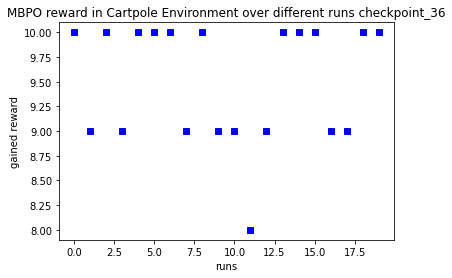

In [33]:
import matplotlib.pyplot as plt
plt.plot(reward_list,'bs')
plt.ylabel('gained reward')
plt.xlabel('runs')
plt.title('MBPO reward in Cartpole Environment over different runs checkpoint_35')
plt.show()